In [32]:
"""
Authors      : Aditya Jain and Safwan Jamal
Date started : November 8, 2022
About        : Convex Optimization project; code for solving convex opt problem
"""

import os
import glob
import numpy as np
import pickle
import cvxpy as cp
import seaborn as sns
import matplotlib.pyplot as plt

#### Reading dissimilarity data data

In [61]:
filename  = open('./dissimilarity_data_pet/beagle_dissimilarity_matrix_150x150.pickle', 'rb')
D         = pickle.load(filename)
n         = len(D)

# variable for plotting
plots_dir = './plots/'
dataset   = 'pet'
category  = 'beagle'

#### Optimization program

In [62]:
# print(D)
ltype = 'linf' # or it will be l-infinity
lambda_max = 0

for i in range(n):
    for j in range(i+1, n):
        if ltype=='l2':
            lambda_cur = (np.sqrt(n)/2)*((np.linalg.norm(D[i, :] - D[j, :])**2)/np.sum((D[i, :] - D[j, :])))  # l2-norm
        else:
            lambda_cur = np.linalg.norm(D[i, :] - D[j, :], ord=1)/2  #l-infinity norm

        if lambda_cur>lambda_max:
            lambda_max = lambda_cur

print(f'Maximum lambda is {lambda_max}')

Maximum lambda is 13.947450715819059


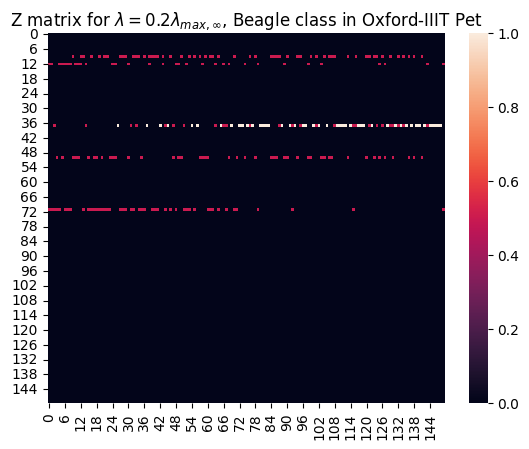

In [74]:
# user variables
ltype         = 'linf'
fac_lamda_max = 0.2

# variable definitions
Z             = cp.Variable((n, n))
lambda_t      = fac_lamda_max*lambda_max


# objective function
cost_encoding = cp.trace(D.T@Z)        # cost of encoding all data points using representatives
cost_no_repr  = 0                      # cost associated with no. of representatives
for i in range(n):
    if ltype=='l2':
        cost_no_repr += cp.norm2(Z[i, :])    # l2 norm
    else:
        cost_no_repr += cp.max(Z[i, :])  # l-infinity norm
cost_no_repr = lambda_t*cost_no_repr

# objective function
objective    = cp.Minimize(cost_encoding + cost_no_repr)

# constraints
# probab. should be >=0
# probabilities should sum to one for every column
constraints = [Z>=0, np.ones((1,n))@Z == np.ones((1,n))]

# optimization program
prob = cp.Problem(objective, constraints)
prob.solve()

# Plotting
ax = plt.axes()
sns_plot = sns.heatmap(Z.value, ax = ax)
plt_title = 'Z matrix for $λ=$' + str(fac_lamda_max) + '$λ_{max, \infty}$, Beagle class in Oxford-IIIT Pet'
# ax.set_title('Z matrix for $λ=1λ_{max, \infty}$, Ship class in CIFAR-10')
ax.set_title(plt_title)
plt.show()

In [75]:
# Saving the plot
sns_figure = sns_plot.get_figure()
sns_figure.savefig(plots_dir + dataset + '_' + \
                category + '_' + ltype + \
                '_' + str(fac_lamda_max) +'.png', dpi=400)